In [1]:
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import sys
import sympy


sys.path.append("../")
import analysis_util, tasks, natural_computation, general_network_visualization

In [2]:
data_path = "boolean_network_data/natural_evolution_results/2023-03-08-17-46-44/batch_1.npz"
data = np.load(os.path.join(os.getenv("DATA_DIR"), data_path))

In [3]:
N = data["N"]
input_state = cp.asnumpy(tasks.make_6_bit_input_state(N))
best_functions = np.expand_dims(data["functions"], 1)
best_conn = np.expand_dims(data["connectivity"], 1)
best_used_conn = np.expand_dims(data["used_connectivity"], 1)
batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_state, 1), 1), (input_state.shape[0], np.shape(best_functions)[0], 1, N)).astype(np.bool_)

In [4]:
input_data_path = os.path.join(os.getenv("DATA_DIR"), "boolean_network_data/natural_evolution_results/2023-03-08-17-46-44/original_data.npz")
data = np.load(input_data_path)

to_use_start = 0
to_use_end = 100

desired_truth_tables = cp.array(data["truth_tables"][to_use_start:to_use_end])
output_nodes = data["output_nodes"][to_use_start:to_use_end]
orig_functions = data["functions"][to_use_start:to_use_end]
orig_connectivity = data["connectivity"][to_use_start:to_use_end]
orig_used_connectivity = data["used_connectivity"][to_use_start:to_use_end]
f_eval = lambda x: natural_computation.eval_natural_task(x, output_nodes, desired_truth_tables)

In [5]:
best_functions, best_conn, best_used_conn, sorted_perfs, perf_order =  analysis_util.sort_by_performance(cp.array(batched_input_state), cp.array(best_functions), cp.array(best_conn), cp.array(best_used_conn), f_eval, n_trajectories=100)
perf_order = cp.asnumpy(perf_order)
sorted_output_nodes = output_nodes[perf_order]
desired_truth_tables = desired_truth_tables[perf_order]
sorted_orig_functions = orig_functions[perf_order]
sorted_orig_connectivity = orig_connectivity[perf_order]
sorted_orig_used_connectivity = orig_used_connectivity[perf_order]

In [6]:
import importlib
importlib.reload(general_network_visualization)
graphs = [general_network_visualization.influence_graph_from_ragged_spec(f[0, :, :], c[0, :, :], uc[0, :, :]) for f, c, uc in zip(cp.asnumpy(best_functions), cp.asnumpy(best_conn), cp.asnumpy(best_used_conn))]
#graphs = [general_network_visualization.influence_graph_from_ragged_spec(f, c, uc) for f, c, uc in zip(cp.asnumpy(sorted_orig_functions), cp.asnumpy(sorted_orig_connectivity), cp.asnumpy(sorted_orig_used_connectivity))]
[g.remove_nodes_from(list(nx.isolates(g))) for g in graphs]
[g.remove_nodes_from(list(nx.isolates(g))) for g in graphs]
[general_network_visualization.prune_non_participating(g, [0, 1, 2, 3, 4, 5]) for  g in graphs]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

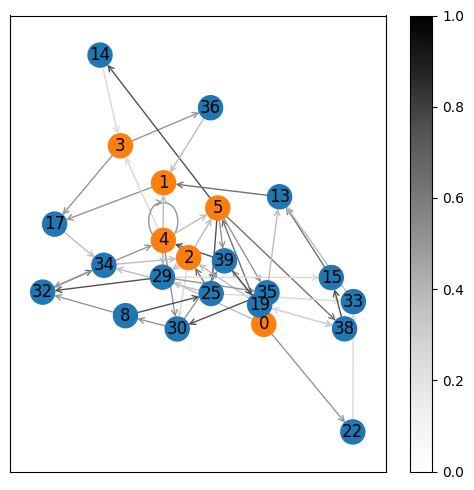

In [7]:
import importlib
importlib.reload(general_network_visualization)
best_to_plot = 1
to_plot = graphs[:best_to_plot]
fig, axs = plt.subplots(ncols=len(to_plot), figsize=(5,5))
if not isinstance(axs, np.ndarray):
    axs = [axs]
node_colors = ["C0"] * int(N)
node_colors[0] = "C1"
node_colors[1] = "C1"
node_colors[2] = "C1"
node_colors[3] = "C1"
node_colors[4] = "C1"
node_colors[5] = "C1"




for i, (g, ax, err) in enumerate(zip(graphs, axs, sorted_perfs[:best_to_plot])):
    pos = nx.spring_layout(g, iterations=50)
    colorbar = True if i==best_to_plot-1 else False
    general_network_visualization.plot_network_directed(g, pos, ax, node_colors[:len(g.nodes)], colorbar=colorbar)
    #ax.set_title("{:.2E}".format(err))
fig.tight_layout()


In [8]:
boolean_syms = sympy.symbols('x0 x1 x2 x3 x4 x5')
all_expressions = []
for analysis_tt in desired_truth_tables:
    all_expressions.append(sympy.logic.boolalg.simplify_logic(sympy.logic.boolalg.ANFform(boolean_syms, analysis_tt), form="dnf"))
